<a href="https://colab.research.google.com/github/viktoriahard/ds/blob/main/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [4]:
import os
import shutil
import zipfile
import pandas as pd
import sqlite3

# Определяем пути источника и назначения
source_path = '/content/sample_data/kaggle.json'
destination_dir = os.path.expanduser('~/.kaggle')
destination_path = os.path.join(destination_dir, 'kaggle.json')

# Создаем директорию назначения, если она не существует
os.makedirs(destination_dir, exist_ok=True)

# Перемещаем файл
shutil.move(source_path, destination_path)

# Устанавливаем права доступа
os.chmod(destination_path, 0o600)

In [5]:
!kaggle datasets download -d redwankarimsony/heart-disease-data

Dataset URL: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data
License(s): copyright-authors
  0% 0.00/12.4k [00:00<?, ?B/s]
100% 12.4k/12.4k [00:00<00:00, 48.6MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('heart-disease-data.zip', 'r') as zip_ref:
    zip_ref.extractall('heart-disease-data')

Исходное распределение классов:
num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

После объединения:
target_binary
0    411
1    509
Name: count, dtype: int64

Объединение:
Класс 0 -> 0 (здоров)
Классы 1,2,3,4 -> 1 (болезнь сердца)

Числовые колонки: ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
Категориальные колонки: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

Размерность данных:
X: (920, 14)
y: (920,)
Распределение классов в y: target_binary
0    411
1    509
Name: count, dtype: int64

Разделение данных:
X_train: (644, 14)
X_test: (276, 14)
y_train распределение: target_binary
0    288
1    356
Name: count, dtype: int64
y_test распределение: target_binary
0    123
1    153
Name: count, dtype: int64
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/tmp/ipython-input-2360797031.py:50: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_binary[categorical_columns] = df_binary[categorical_columns].fillna(df_binary[categorical_columns].mode().iloc[0])


Лучшие параметры: {'learning_rate': 0.4, 'max_depth': 1, 'n_estimators': 200}
Лучшая точность (CV): 0.8245639534883722
Training Accuracy: 0.89
Accuracy на тестовых данных: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       123
           1       0.82      0.85      0.84       153

    accuracy                           0.82       276
   macro avg       0.81      0.81      0.81       276
weighted avg       0.81      0.82      0.81       276



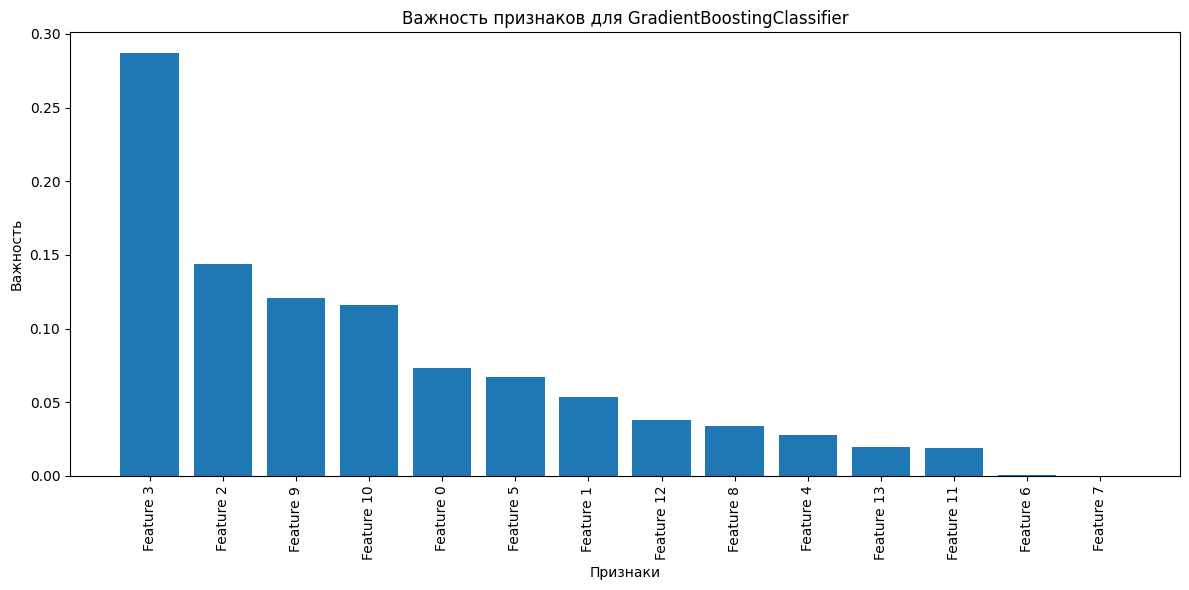

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('/content/heart-disease-data/heart_disease_uci.csv')
df = df.drop('id', axis=1)

# Анализ исходных классов
print("Исходное распределение классов:")
original_distribution = df['num'].value_counts().sort_index()
print(original_distribution)

# Объединение классов: 0 vs 1+2+3+4
df_binary = df.copy()
df_binary['target_binary'] = df_binary['num'].apply(lambda x: 0 if x == 0 else 1)

print("\nПосле объединения:")
binary_distribution = df_binary['target_binary'].value_counts().sort_index()
print(binary_distribution)

print(f"\nОбъединение:")
print("Класс 0 -> 0 (здоров)")
print("Классы 1,2,3,4 -> 1 (болезнь сердца)")

# Удаляем ненужные колонки
# df_binary = df_binary.drop('id', axis=1)  # Удаляем id
df_binary = df_binary.drop('num', axis=1)  # Удаляем исходную целевую переменную!

# Разделение столбцов на числовые и категориальные
numeric_columns = df_binary.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df_binary.select_dtypes(include=['object']).columns.tolist()

# Убедимся, что целевая переменная не входит в числовые столбцы
if 'target_binary' in numeric_columns:
    numeric_columns.remove('target_binary')

print(f"\nЧисловые колонки: {numeric_columns}")
print(f"Категориальные колонки: {categorical_columns}")

# Обработка пропущенных значений для числовых столбцов
if df_binary[numeric_columns].isnull().sum().any():
   df_binary[numeric_columns] = df_binary[numeric_columns].fillna(df_binary[numeric_columns].median())

# Обработка пропущенных значений для категориальных столбцов
if df_binary[categorical_columns].isnull().sum().any():
   df_binary[categorical_columns] = df_binary[categorical_columns].fillna(df_binary[categorical_columns].mode().iloc[0])

# Кодирование категориальных признаков с использованием LabelEncoder
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df_binary[column] = le.fit_transform(df_binary[column].astype(str))
    label_encoders[column] = le

# Теперь используем бинарную целевую переменную
X = df_binary.drop('target_binary', axis=1)
y = df_binary['target_binary']  # Используем объединенную целевую переменную

print(f"\nРазмерность данных:")
print(f"X: {X.shape}")
print(f"y: {y.shape}")
print(f"Распределение классов в y: {y.value_counts().sort_index()}")

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nРазделение данных:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train распределение: {y_train.value_counts().sort_index()}")
print(f"y_test распределение: {y_test.value_counts().sort_index()}")


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 5, 10],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Инициализация GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и точности
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность (CV):", grid_search.best_score_)

# Использование лучшей модели для прогнозирования
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
y_train_pred = best_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Accuracy на тестовых данных: {accuracy:.2f}')
print('Classification Report:')
print(report)

feature_importances = best_clf.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Важность признаков для GradientBoostingClassifier")
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), [f'Feature {i}' for i in indices], rotation=90)
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.tight_layout()
plt.show()

In [17]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


In [29]:
from catboost import CatBoostClassifier

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
y_train_pred = best_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Accuracy на тестовых данных: {accuracy:.2f}')
print('Classification Report:')
print(report)

Training Accuracy: 0.98
Accuracy на тестовых данных: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       123
           1       0.84      0.85      0.84       153

    accuracy                           0.83       276
   macro avg       0.82      0.82      0.82       276
weighted avg       0.83      0.83      0.83       276



In [30]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)

# Оценка модели
y_pred = dummy_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.5289855072463768
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.42      0.44       123
           1       0.57      0.61      0.59       153

    accuracy                           0.53       276
   macro avg       0.52      0.52      0.52       276
weighted avg       0.52      0.53      0.53       276

Confusion Matrix:
[[52 71]
 [59 94]]


Accuracy: 0.8152173913043478
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       123
           1       0.85      0.80      0.83       153

    accuracy                           0.82       276
   macro avg       0.81      0.82      0.81       276
weighted avg       0.82      0.82      0.82       276

Confusion Matrix:
[[102  21]
 [ 30 123]]


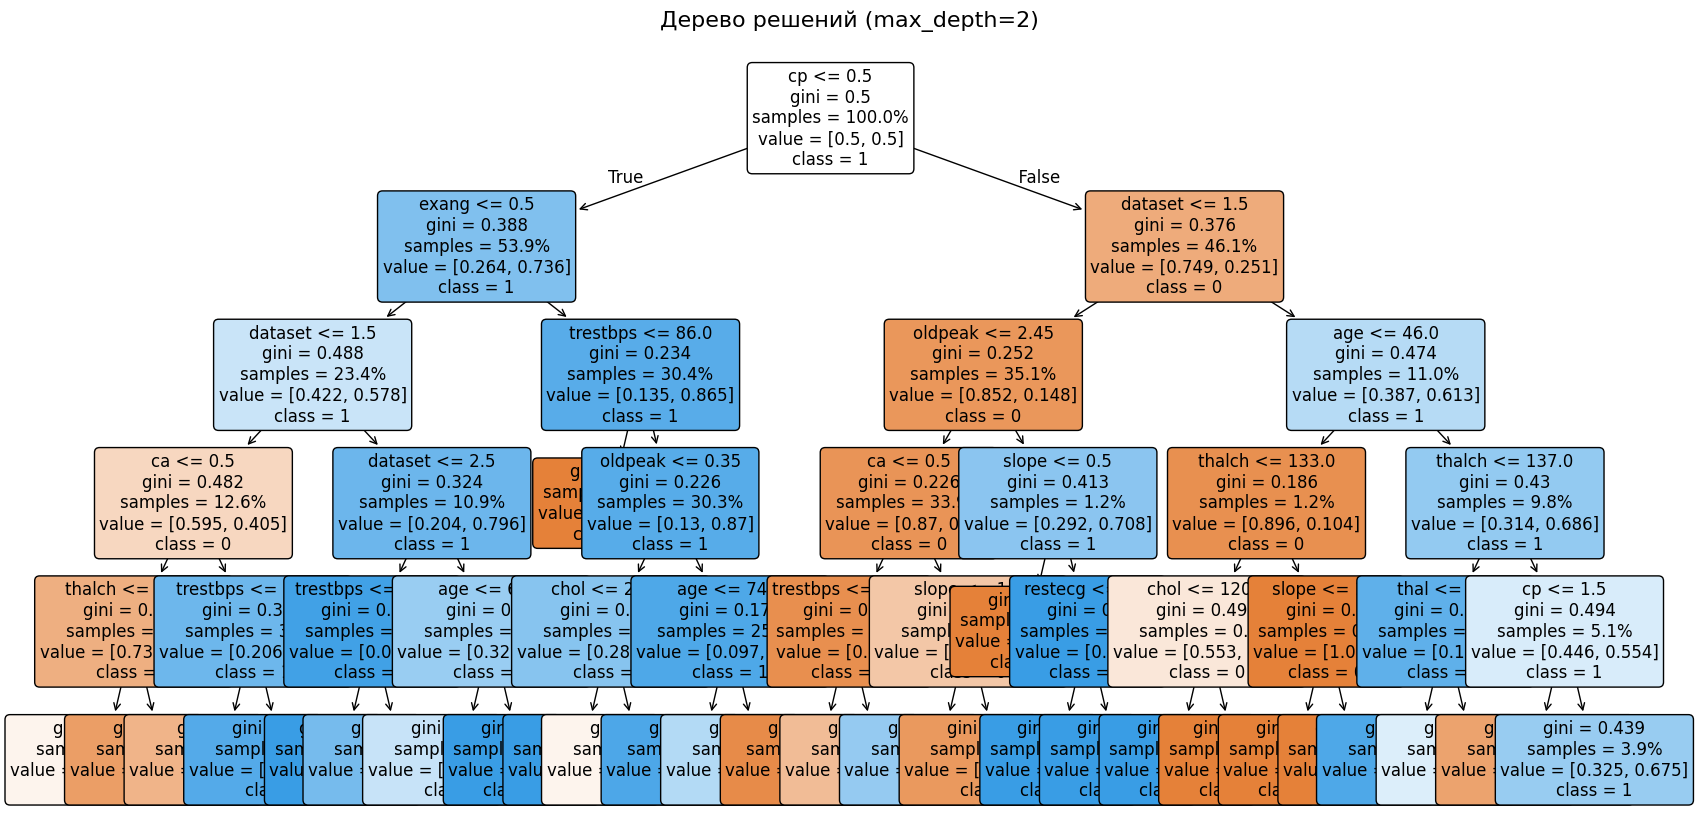


АНАЛИЗ СТРУКТУРЫ ДЕРЕВА РЕШЕНИЙ

1. ОСНОВНАЯ ИНФОРМАЦИЯ:
   - Глубина дерева: 5
   - Количество листьев: 28
   - Количество признаков: 14
   - Классы: [0 1]

2. ВАЖНОСТЬ ПРИЗНАКОВ:
 Признак     Важность
      cp 4.350436e-01
 dataset 2.065764e-01
   exang 7.439843e-02
      ca 6.727071e-02
     age 4.375821e-02
   slope 3.770634e-02
 oldpeak 3.753404e-02
trestbps 3.399470e-02
    chol 2.937199e-02
  thalch 2.865792e-02
    thal 5.687611e-03
 restecg 1.002676e-17
     sex 0.000000e+00
     fbs 0.000000e+00


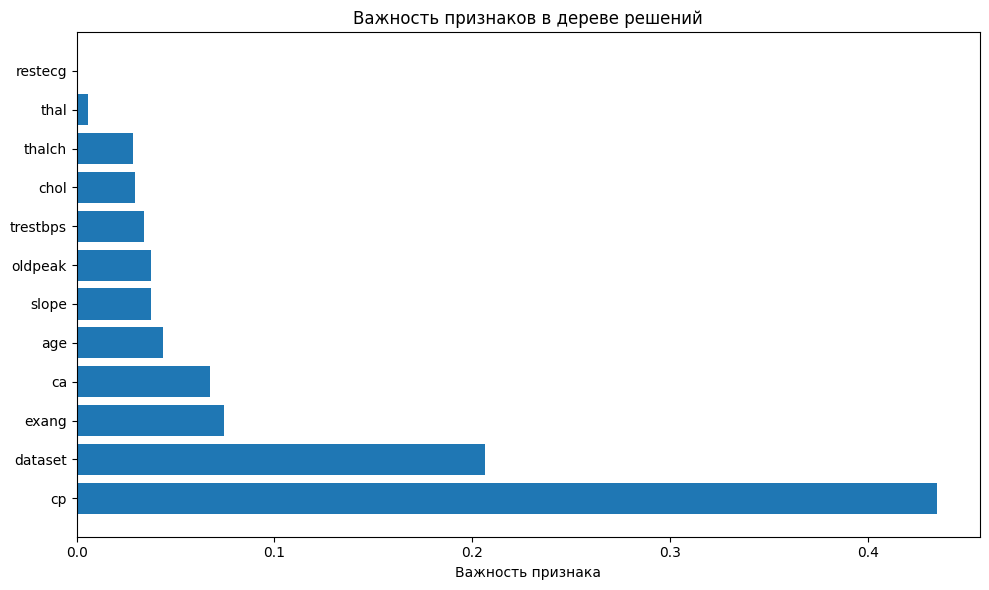

In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

# Оценка модели
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

plt.figure(figsize=(20, 10))

# Получаем названия признаков
feature_names = X_train.columns.tolist() if hasattr(X_train, 'columns') else [f'Feature_{i}' for i in range(X_train.shape[1])]

# Получаем названия классов
class_names = [str(i) for i in clf.classes_]

# Визуализируем дерево
plot_tree(clf,
          feature_names=feature_names,
          class_names=class_names,
          filled=True,
          rounded=True,
          fontsize=12,
          proportion=True)

plt.title('Дерево решений (max_depth=2)', fontsize=16, pad=20)
plt.show()

# АНАЛИЗ СТРУКТУРЫ ДЕРЕВА
print("\n" + "="*60)
print("АНАЛИЗ СТРУКТУРЫ ДЕРЕВА РЕШЕНИЙ")
print("="*60)

# 1. Информация о дереве
print(f"\n1. ОСНОВНАЯ ИНФОРМАЦИЯ:")
print(f"   - Глубина дерева: {clf.get_depth()}")
print(f"   - Количество листьев: {clf.get_n_leaves()}")
print(f"   - Количество признаков: {clf.n_features_in_}")
print(f"   - Классы: {clf.classes_}")

# 2. Важность признаков
print(f"\n2. ВАЖНОСТЬ ПРИЗНАКОВ:")
feature_importance = pd.DataFrame({
    'Признак': feature_names,
    'Важность': clf.feature_importances_
}).sort_values('Важность', ascending=False)

print(feature_importance.to_string(index=False))

# Визуализация важности признаков
plt.figure(figsize=(10, 6))
important_features = feature_importance[feature_importance['Важность'] > 0]
plt.barh(important_features['Признак'], important_features['Важность'])
plt.xlabel('Важность признака')
plt.title('Важность признаков в дереве решений')
plt.tight_layout()
plt.show()


In [40]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Создание и обучение модели K Neighbors
knn = KNeighborsClassifier(n_neighbors=3)  # Задаем количество соседей (K=3)
knn.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = knn.predict(X_test)

# Вывод метрик
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6485507246376812

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.65      0.59       110
           1       0.73      0.65      0.69       166

    accuracy                           0.65       276
   macro avg       0.64      0.65      0.64       276
weighted avg       0.66      0.65      0.65       276



In [44]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]
}

# Инициализация AdaBoostClassifier
clf = AdaBoostClassifier(random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод лучших параметров и точности
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность (CV):", grid_search.best_score_)

# Использование лучшей модели для прогнозирования
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
y_train_pred = best_clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)


print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Лучшие параметры: {'learning_rate': 0.4, 'n_estimators': 100}
Лучшая точность (CV): 0.8261022286821706
Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78       110
           1       0.87      0.81      0.84       166

    accuracy                           0.82       276
   macro avg       0.81      0.82      0.81       276
weighted avg       0.82      0.82      0.82       276



Выходные данные были обрезаны до нескольких последних строк (5000).
20:	learn: 0.6068910	total: 28.4ms	remaining: 1.32s
21:	learn: 0.6029418	total: 29.6ms	remaining: 1.32s
22:	learn: 0.5990291	total: 30.7ms	remaining: 1.3s
23:	learn: 0.5958645	total: 31.8ms	remaining: 1.29s
24:	learn: 0.5928219	total: 32.8ms	remaining: 1.28s
25:	learn: 0.5897907	total: 33.9ms	remaining: 1.27s
26:	learn: 0.5868513	total: 35ms	remaining: 1.26s
27:	learn: 0.5832594	total: 36ms	remaining: 1.25s
28:	learn: 0.5797182	total: 37.1ms	remaining: 1.24s
29:	learn: 0.5760651	total: 38.1ms	remaining: 1.23s
30:	learn: 0.5733369	total: 39.2ms	remaining: 1.23s
31:	learn: 0.5705067	total: 40.3ms	remaining: 1.22s
32:	learn: 0.5681695	total: 41.4ms	remaining: 1.21s
33:	learn: 0.5653368	total: 42.4ms	remaining: 1.21s
34:	learn: 0.5621502	total: 43.5ms	remaining: 1.2s
35:	learn: 0.5593923	total: 44.6ms	remaining: 1.19s
36:	learn: 0.5565380	total: 45.6ms	remaining: 1.19s
37:	learn: 0.5538814	total: 46.7ms	remaining: 1.18s
38

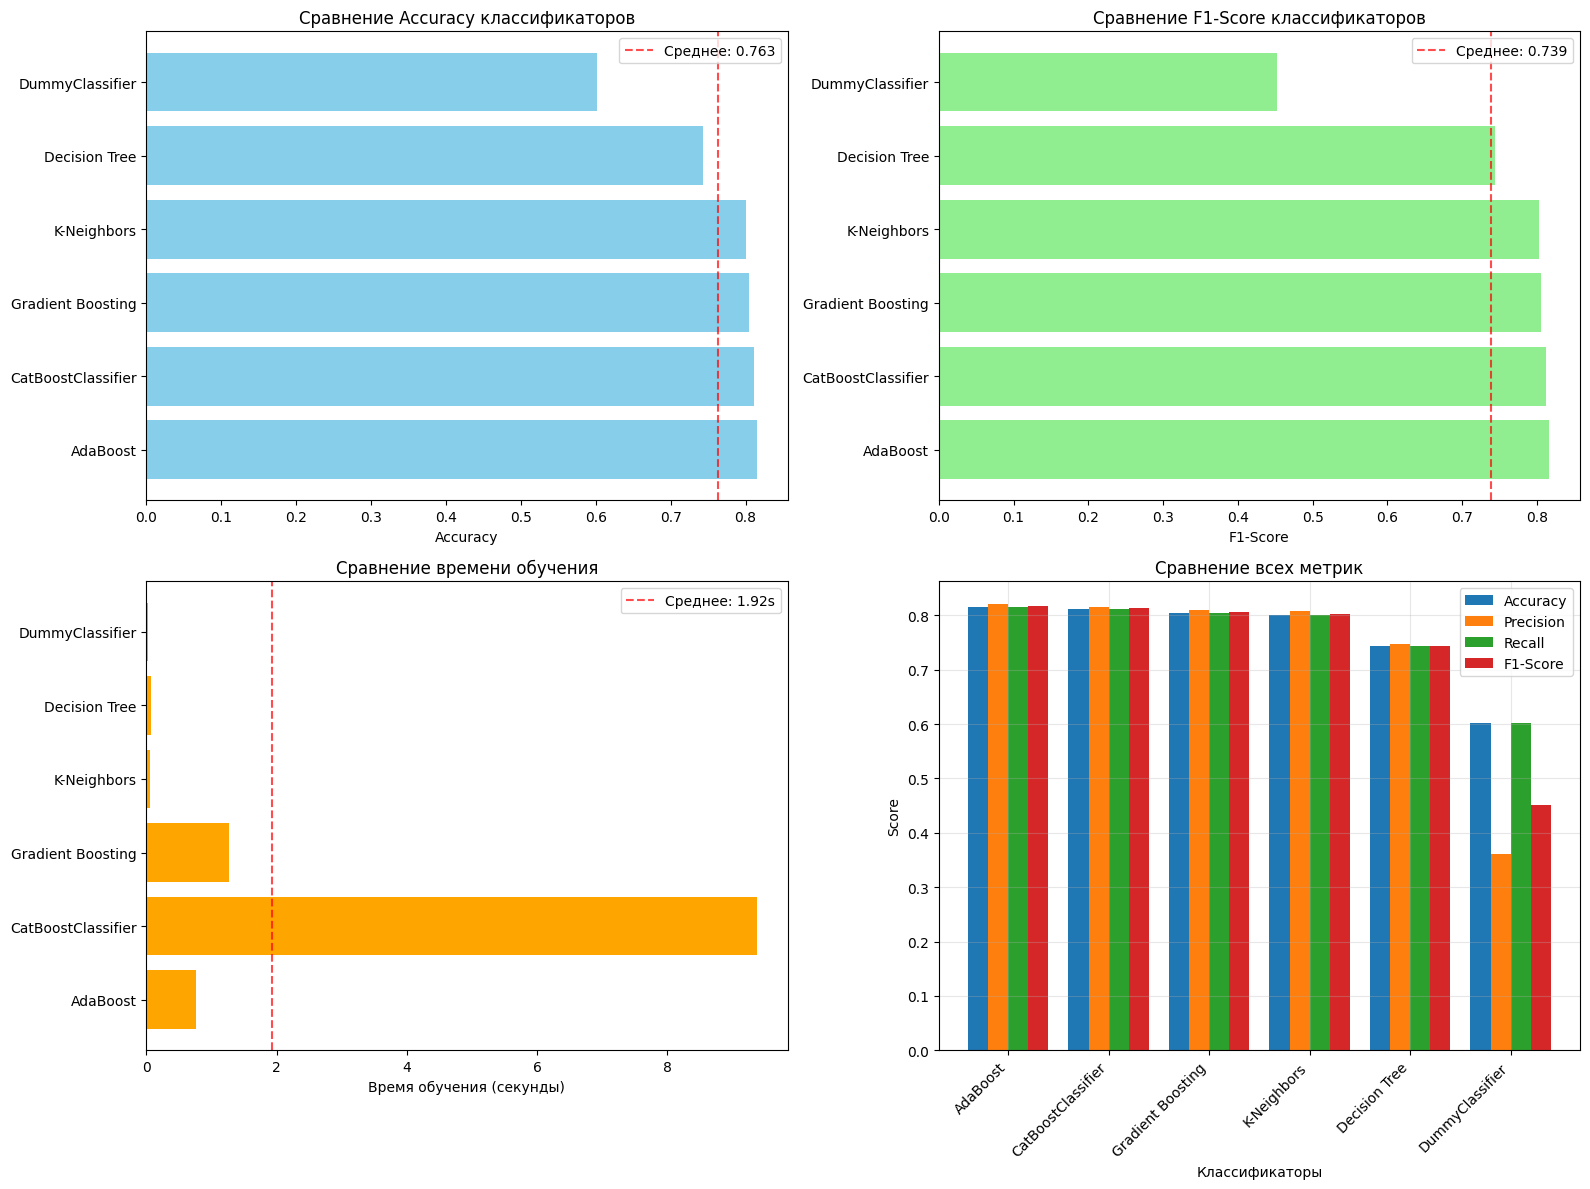


ДЕТАЛЬНЫЙ ОТЧЕТ ЛУЧШЕГО КЛАССИФИКАТОРА: AdaBoost

Accuracy: 0.8152
Precision: 0.8216
Recall: 0.8152
F1-Score: 0.8166

Classification Report:
                    precision    recall  f1-score   support

        Здоров (0)       0.74      0.83      0.78       110
Болезнь сердца (1)       0.88      0.81      0.84       166

          accuracy                           0.82       276
         macro avg       0.81      0.82      0.81       276
      weighted avg       0.82      0.82      0.82       276



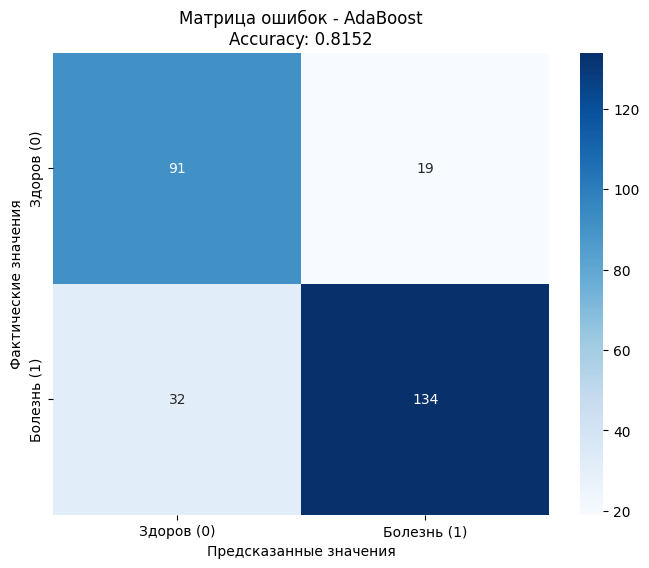


Топ-10 самых важных признаков:
     feature  importance
3         cp    0.169649
10   oldpeak    0.143103
5       chol    0.118490
2    dataset    0.092526
0        age    0.091164
12        ca    0.082591
8     thalch    0.072569
9      exang    0.053927
1        sex    0.048922
4   trestbps    0.048194


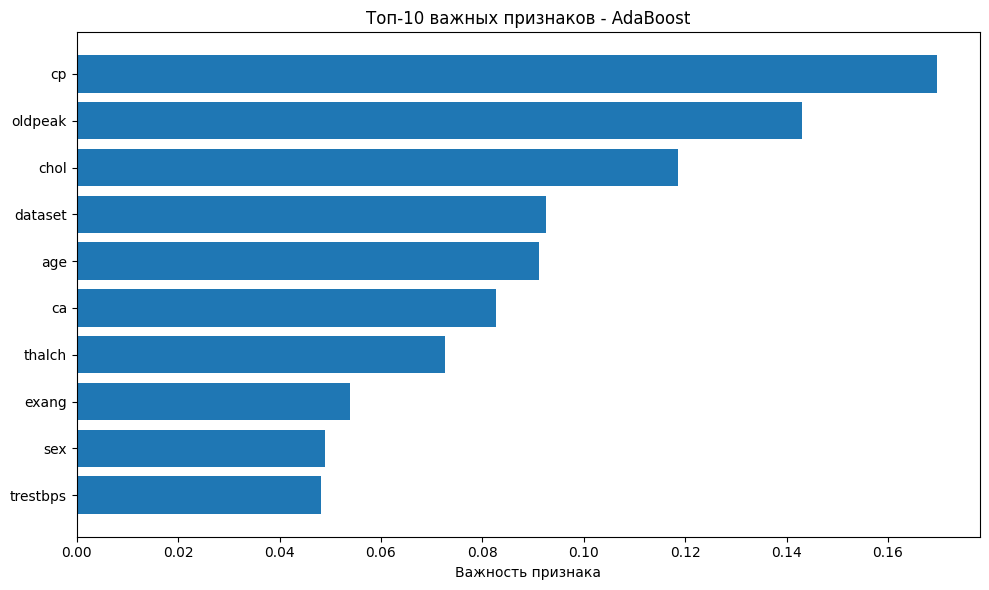

In [51]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import time
from warnings import filterwarnings
filterwarnings('ignore')


classifiers = {

    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'DummyClassifier': DummyClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Neighbors': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'CatBoostClassifier': CatBoostClassifier()
}

# Для масштабирования данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Сравнение классификаторов
results = []
best_accuracy = 0
best_classifier = None
best_model = None

for name, classifier in classifiers.items():

    start_time = time.time()

    try:

        if name in ['K-Neighbors']:
            X_tr, X_te = X_train_scaled, X_test_scaled
        else:
            X_tr, X_te = X_train, X_test

        # Обучение модели
        classifier.fit(X_tr, y_train)

        # Предсказания
        y_pred = classifier.predict(X_te)

        # Метрики
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Кросс-валидация
        cv_scores = cross_val_score(classifier, X_tr, y_train, cv=5, scoring='accuracy')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        # Время обучения
        training_time = time.time() - start_time

        # Сохраняем результаты
        result = {
            'Classifier': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'CV Mean': cv_mean,
            'CV Std': cv_std,
            'Training Time': training_time
        }
        results.append(result)

        # Проверяем на лучший классификатор
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_classifier = name
            best_model = classifier


    except Exception as e:
        continue

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n" + "=" * 70)
print("ИТОГОВЫЙ ОТЧЕТ СРАВНЕНИЯ КЛАССИФИКАТОРОВ")
print("=" * 70)

# Выводим таблицу результатов
print("\nРейтинг классификаторов (по Accuracy):")
print("-" * 90)
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    print(f"{i:2d}. {row['Classifier']:20} | "
          f"Acc: {row['Accuracy']:.4f} | "
          f"Prec: {row['Precision']:.4f} | "
          f"Rec: {row['Recall']:.4f} | "
          f"F1: {row['F1-Score']:.4f} | "
          f"CV: {row['CV Mean']:.4f} ± {row['CV Std']:.4f}")

print(f"\n ЛУЧШИЙ КЛАССИФИКАТОР: {best_classifier}")
print(f"Лучшая точность: {best_accuracy:.4f}")

# ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Сравнение Accuracy
axes[0, 0].barh(results_df['Classifier'], results_df['Accuracy'], color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Сравнение Accuracy классификаторов')
axes[0, 0].axvline(x=results_df['Accuracy'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Среднее: {results_df["Accuracy"].mean():.3f}')
axes[0, 0].legend()

# 2. Сравнение F1-Score
axes[0, 1].barh(results_df['Classifier'], results_df['F1-Score'], color='lightgreen')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].set_title('Сравнение F1-Score классификаторов')
axes[0, 1].axvline(x=results_df['F1-Score'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Среднее: {results_df["F1-Score"].mean():.3f}')
axes[0, 1].legend()

# 3. Время обучения
axes[1, 0].barh(results_df['Classifier'], results_df['Training Time'], color='orange')
axes[1, 0].set_xlabel('Время обучения (секунды)')
axes[1, 0].set_title('Сравнение времени обучения')
axes[1, 0].axvline(x=results_df['Training Time'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Среднее: {results_df["Training Time"].mean():.2f}s')
axes[1, 0].legend()

# 4. Сравнение всех метрик
metrics_comparison = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
x_pos = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1-Score']):
    axes[1, 1].bar(x_pos + i*width, results_df[metric], width, label=metric)

axes[1, 1].set_xlabel('Классификаторы')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Сравнение всех метрик')
axes[1, 1].set_xticks(x_pos + 1.5*width)
axes[1, 1].set_xticklabels(results_df['Classifier'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ДЕТАЛЬНЫЙ ОТЧЕТ ЛУЧШЕГО КЛАССИФИКАТОРА
print("\n" + "=" * 70)
print(f"ДЕТАЛЬНЫЙ ОТЧЕТ ЛУЧШЕГО КЛАССИФИКАТОРА: {best_classifier}")
print("=" * 70)

# Предсказания лучшей модели
if best_model:

    if best_classifier in ['K-Neighbors']:
        y_pred_best = best_model.predict(X_test_scaled)
    else:
        y_pred_best = best_model.predict(X_test)

    print(f"\nAccuracy: {accuracy_score(y_test, y_pred_best):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_best, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_best, average='weighted'):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_best, average='weighted'):.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_best, target_names=['Здоров (0)', 'Болезнь сердца (1)']))

    # Матрица ошибок лучшего классификатора
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_best)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Здоров (0)', 'Болезнь (1)'],
                yticklabels=['Здоров (0)', 'Болезнь (1)'])
    plt.title(f'Матрица ошибок - {best_classifier}\nAccuracy: {accuracy_score(y_test, y_pred_best):.4f}')
    plt.ylabel('Фактические значения')
    plt.xlabel('Предсказанные значения')
    plt.show()

    # Важность признаков (если доступно)
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nТоп-10 самых важных признаков:")
        print(feature_importance.head(10))

        # Визуализация важности признаков
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(10)
        plt.barh(top_features['feature'], top_features['importance'])
        plt.xlabel('Важность признака')
        plt.title(f'Топ-10 важных признаков - {best_classifier}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()